# Skip ahead — these first few things just gather data

In [212]:
from ingest import ingest
import matplotlib
import matplotlib.pyplot as plt
import common
import pandas as pd
matplotlib.style.use('ggplot')

In [213]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}

<IPython.core.display.Javascript object>

In [214]:
%%capture log
source = ingest("orchestration")

In [215]:
lobsters = source['lobsters-noria'].copy()
lobsters = lobsters.query("until <= 512")
lobsters["vmrss"] = lobsters["vmrss"] / (1024 * 1024 * 1024)
lobsters["basemem"] = lobsters["basemem"] / (1024 * 1024 * 1024)
lobsters["opmem"] = lobsters["opmem"] / (1024 * 1024 * 1024)
lobsters["rmem"] = lobsters["rmem"] / (1024 * 1024 * 1024)
lobsters["mem"] = lobsters["basemem"] + lobsters["opmem"]
lobsters.sort_index(inplace = True)

In [216]:
vote = source['vote'].copy()
vote = vote.query("until <= 512")
vote["vmrss"] = vote["vmrss"] / (1024 * 1024 * 1024)
vote["basemem"] = vote["basemem"] / (1024 * 1024 * 1024)
vote["opmem"] = vote["opmem"] / (1024 * 1024 * 1024)
vote["rmem"] = vote["rmem"] / (1024 * 1024 * 1024)
vote["mem"] = vote["basemem"] + vote["opmem"]
vote["aggmem"] = vote["opmem"] - vote["rmem"]
vote.sort_index(inplace = True)

**Prune out datapoints where the server did not keep up — results are likely misleading**

In [217]:
# prune all points where 50% > 100ms
prune = []
x = lobsters.reset_index().set_index(["scale", "partial", "memlimit", "op"])
x = x.query("op != 'all'")
x = x.groupby(x.index.names)["median"].min()
x = x.reset_index().set_index(["scale", "partial", "memlimit"])
x = x.groupby(x.index.names).max()
for row in x.query('median > 100').itertuples():
    print(row.Index, row.median, "ms")
    prune.append(row.Index)
for index in prune:
    lobsters = lobsters.drop(index = index)

# prune all points where achieved != target
prune = []
for row in lobsters.query('achieved < 0.95 * requested').itertuples():
    print(row.Index, row.achieved, "achieved of", row.requested, "requested ops/s")
    prune.append(row.Index)
for index in prune:
    lobsters = lobsters.drop(index = index)

In [218]:
# prune all points where 50% > 100ms
prune = []
x = vote.reset_index().set_index(["target", "partial", "distribution", "write_every", "clients", "articles", "memlimit", "op"])
x = x.query("op != 'all'")
x = x.groupby(x.index.names)["median"].min()
x = x.reset_index().set_index(["target", "partial", "distribution", "write_every", "clients", "articles", "memlimit"])
x = x.groupby(x.index.names).max()
for row in x.query('median > 100').itertuples():
    print(row.Index, row.median, "ms")
    prune.append(row.Index)
for index in prune:
    vote = vote.drop(index = index)

# prune all points where achieved != target
prune = []
for row in vote.query('achieved < 0.95 * target').itertuples():
    print(row.Index, "only achieved", row.achieved, "ops/s")
    prune.append(row.Index)
for index in prune:
    vote = vote.drop(index = index)

(1600000, True, 'uniform', 20, 6, 5000000, 0.0) 245.75900000000001 ms
(800000, True, 'skewed', 20, 6, 5000000, 0.0625, 'all', 1, 'processing') only achieved 755208.08 ops/s
(800000, True, 'skewed', 20, 6, 5000000, 0.0625, 'all', 1, 'sojourn') only achieved 755208.08 ops/s
(800000, True, 'skewed', 20, 6, 5000000, 0.0625, 'all', 2, 'processing') only achieved 755208.08 ops/s
(800000, True, 'skewed', 20, 6, 5000000, 0.0625, 'all', 2, 'sojourn') only achieved 755208.08 ops/s
(800000, True, 'skewed', 20, 6, 5000000, 0.0625, 'all', 4, 'processing') only achieved 755208.08 ops/s
(800000, True, 'skewed', 20, 6, 5000000, 0.0625, 'all', 4, 'sojourn') only achieved 755208.08 ops/s
(800000, True, 'skewed', 20, 6, 5000000, 0.0625, 'all', 8, 'processing') only achieved 755208.08 ops/s
(800000, True, 'skewed', 20, 6, 5000000, 0.0625, 'all', 8, 'sojourn') only achieved 755208.08 ops/s
(800000, True, 'skewed', 20, 6, 5000000, 0.0625, 'all', 16, 'processing') only achieved 755208.08 ops/s
(800000, True,

In [219]:
lobsters_experiments = lobsters.query('op == "all" & memlimit == 0').groupby([c for c in lobsters.index.names if c not in ["op", "until", "metric"]]).tail(1)
lobsters_experiments

mean  median    p25      p90  \
scale partial memlimit op  until metric                                        
500   False   0.0      all 512   sojourn    1.573339   1.666  1.627    1.758   
      True    0.0      all 256   sojourn    3.624898   3.669  3.139    4.171   
1000  False   0.0      all 512   sojourn    1.555884   1.653  1.613    1.735   
      True    0.0      all 512   sojourn    8.508258   3.723  3.119    4.069   
2000  False   0.0      all 512   sojourn    1.560433   1.656  1.610    1.748   
      True    0.0      all 512   sojourn   23.608111   3.727  3.141    4.119   
3000  True    0.0      all 512   sojourn   86.917923   3.757  3.183    4.199   
4000  False   0.0      all 512   sojourn    1.607528   1.701  1.636    1.834   
      True    0.0      all 512   sojourn  147.375916   3.889  3.307    4.491   
4500  True    0.0      all 512   sojourn  618.034871   3.983  3.391    5.019   
6000  True    0.0      all 512   sojourn  757.681151   4.187  3.597  172.031   

                                               p95        p99        max  \
scale partial memlimit op  until metric                                    
500   False   0.0      all 512   sojourn     1.791      1.863     10.543   
      True    0.0      all 256   sojourn     4.411      7.179      7.647   
1000  False   0.0      all 512   sojourn     1.763      1.823     19.455   
      True    0.0      all 512   sojourn     4.203      7.327   1527.807   
2000  False   0.0      all 512   sojourn     1.779      1.844     41.567   
      True    0.0      all 512   sojourn     4.251    742.911   3059.711   
3000  True    0.0      all 512   sojourn     4.451   3760.127   5906.431   
4000  False   0.0      all 512   sojourn     1.878      1.969     17.727   
      True    0.0      all 512   sojourn     4.975   5570.559   7589.887   
4500  True    0.0      all 512   sojourn  5718.015  13066.239  14983.167   
6000  True    0.0      all 512   sojourn  7696.383  13762.559  15556.607   

                                          requested  achieved  ndomains  \
scale partial memlimit op  until metric                                   
500   False   0.0      all 512   sojourn     383.33    382.64        51   
      True    0.0      all 256   sojourn     383.33    383.60        51   
1000  False   0.0      all 512   sojourn     766.67    766.40        51   
      True    0.0      all 512   sojourn     766.67    766.18        51   
2000  False   0.0      all 512   sojourn    1533.33   1532.96        51   
      True    0.0      all 512   sojourn    1533.33   1534.58        51   
3000  True    0.0      all 512   sojourn    2300.00   2300.26        51   
4000  False   0.0      all 512   sojourn    3066.67   3069.34        51   
      True    0.0      all 512   sojourn    3066.67   3068.77        51   
4500  True    0.0      all 512   sojourn    3450.00   3448.70        51   
6000  True    0.0      all 512   sojourn    4600.00   4593.56        51   

                                          sload1  sload5  cload1  cload5  \
scale partial memlimit op  until metric                                    
500   False   0.0      all 512   sojourn    0.33    1.45    1.19    2.28   
      True    0.0      all 256   sojourn    0.81    1.66    1.57    2.33   
1000  False   0.0      all 512   sojourn    0.52    0.61    1.95    1.93   
      True    0.0      all 512   sojourn    1.13    1.40    1.98    1.90   
2000  False   0.0      all 512   sojourn    0.83    0.91    2.22    2.57   
      True    0.0      all 512   sojourn    1.83    2.10    2.04    2.25   
3000  True    0.0      all 512   sojourn    2.58    3.13    2.92    3.36   
4000  False   0.0      all 512   sojourn    1.09    1.39    2.89    3.54   
      True    0.0      all 512   sojourn    3.38    3.64    3.21    3.51   
4500  True    0.0      all 512   sojourn    3.81    4.02    3.27    3.62   
6000  True    0.0      all 512   sojourn    4.72    4.48    3.90    4.06   

                                              vmrss  

In [220]:
vote_experiments = vote.query('op == "all" & memlimit == 0').groupby([c for c in vote.index.names if c not in ["op", "until", "metric"]]).tail(1)
vote_experiments

mean  \
target  partial distribution write_every clients articles memlimit op  until metric               
100000  False   skewed       20          6       5000000  0.0      all 512   sojourn   0.114730   
                uniform      20          6       5000000  0.0      all 512   sojourn   0.170237   
        True    skewed       20          6       5000000  0.0      all 512   sojourn   0.252007   
                uniform      20          6       5000000  0.0      all 512   sojourn   0.311267   
200000  False   skewed       20          6       5000000  0.0      all 512   sojourn   0.129858   
                uniform      20          6       5000000  0.0      all 512   sojourn   0.228088   
        True    skewed       20          6       5000000  0.0      all 512   sojourn   0.343669   
                uniform      20          6       5000000  0.0      all 512   sojourn   0.208336   
400000  False   skewed       20          6       5000000  0.0      all 512   sojourn   0.246749   
                uniform      20          6       5000000  0.0      all 512   sojourn   0.287192   
        True    skewed       20          6       5000000  0.0      all 512   sojourn   0.377094   
                uniform      20          6       5000000  0.0      all 512   sojourn   0.295600   
800000  False   skewed       20          6       5000000  0.0      all 512   sojourn   0.421983   
                uniform      20          6       5000000  0.0      all 512   sojourn   0.410791   
        True    skewed       20          6       5000000  0.0      all 512   sojourn   0.463288   
                uniform      20          6       5000000  0.0      all 512   sojourn   0.425686   
1000000 True    skewed       20          6       5000000  0.0      all 512   sojourn   1.293526   
1200000 False   skewed       20          6       5000000  0.0      all 512   sojourn   0.557869   
                uniform      20          6       5000000  0.0      all 512   sojourn   0.507176   
        True    skewed       20          6       5000000  0.0      all 512   sojourn   1.838903   
                uniform      20          6       5000000  0.0      all 512   sojourn   0.586243   
1225000 True    uniform      20          6       5000000  0.0      all 512   sojourn   0.656369   
1250000 True    uniform      20          6       5000000  0.0      all 512   sojourn  16.477344   
1300000 False   uniform      20          6       5000000  0.0      all 512   sojourn   0.562191   
        True    uniform      20          6       5000000  0.0      all 512   sojourn  16.892168   
1325000 False   uniform      20          6       5000000  0.0      all 512   sojourn  13.288242   
1350000 False   uniform      20          6       5000000  0.0      all 512   sojourn  15.157256   
1400000 False   skewed       20          6       5000000  0.0      all 512   sojourn   0.591661   
                uniform      20          6       5000000  0.0      all 512   sojourn  15.683400   
        True    skewed       20          6       5000000  0.0      all 512   sojourn   0.800701   
                uniform      20          6       5000000  0.0      all 512   sojourn  17.692375   
1450000 True    skewed       20          6       5000000  0.0      all 512   sojourn   0.827938   
1475000 True    skewed       20          6       5000000  0.0      all 512   sojourn   2.385827   
1500000 False   skewed       20          6       5000000  0.0      all 512   sojourn   0.518014   
        True    skewed       20          6       5000000  0.0      all 512   sojourn   3.671426   
1550000 False   skewed       20          6       5000000  0.0      all 512   sojourn   6.556965   
1575000 False   skewed       20          6       5000000  0.0      all 512   sojourn  13.031310   
1600000 False   skewed       20          6       5000000  0.0      all 512   sojourn  12.792742   
                uniform      20          6       5000000  0.0      all 512   sojourn  18.073448   
        True    skewed       20 

In [221]:
# determine max scale/target
mx1 = vote["achieved"].max()
mx2 = vote.reset_index()["target"].max()
max_target = max([mx1, mx2]) * 1.1
print("Max target is", max_target)
max_scale = lobsters.reset_index()["scale"].max() * 1.1
max_pps = (46.0 / 60.0) * max_scale # BASE_OPS_PER_MIN
print("Max scale is %f (%f pages per second)" % (max_scale, max_pps))

Max target is 1760000.0000000002
Max scale is 6600.000000 (5060.000000 pages per second)


In [222]:
limited_vote_target = 800000
limited_vote = vote.query('op == "all" & memlimit != 0 & target == %d' % limited_vote_target).groupby('memlimit').tail(1).reset_index()
limited_vote_still_ok = limited_vote.query('achieved >= 0.99 * target')["memlimit"].min()
limited_vote = vote.query('op == "all" & memlimit == %f & target == %d' % (limited_vote_still_ok, limited_vote_target)).tail(1).copy()
print('Using %.0fMB memory limit as representative for vote (achieved %d ops/s)' % (limited_vote_still_ok * 1024, limited_vote["achieved"].min()))
limited_lobsters_scale = 2000
limited_lobsters = lobsters.query('op == "all" & memlimit != 0 & scale == %d' % limited_lobsters_scale).groupby('memlimit').tail(1).reset_index()
limited_lobsters_still_ok = limited_lobsters.query('achieved >= 0.99 * requested')["memlimit"].min()
limited_lobsters = lobsters.query('op == "all" & memlimit == %f & scale == %d' % (limited_lobsters_still_ok, limited_lobsters_scale)).tail(1).copy()
print('Using %.0fMB memory limit as representative for lobsters (%d pages/s)' % (limited_lobsters_still_ok * 1024, limited_lobsters["achieved"].min()))

Using 96MB memory limit as representative for vote (achieved 797909 ops/s)
Using 32MB memory limit as representative for lobsters (1532 pages/s)


## Things that are missing (a.k.a. TODO)

### Eviction

Without eviction, as time goes on, the working set approaches full materialization, since every query parameter in the tail will have been sampled. In other words, without eviction, partial doesn't actually help in the long run. So, we need to have experiments that demonstrate that eviction works. Of course, this may have some problems, since Noria currently only supports _randomized_ eviction.

Some things to keep in mind:

 - As the application runs for longer, the data set size grows, **and so does its working set**. So, even with eviction turned on, memory use will grow over time.

#### Experiment: memory limit over time

Pick a particular scaling factor. Run for `t` seconds and measure memory use, `m`. Run for another `t`. Save as dataset `A`. Start a new run with the same scaling factor and a memory limit of `m`. Run for `2t` and save as dataset `B`. Plot `A` and `B` with time on the x-axis. Several y-axes are interesting here. Primarily: latency, throughput, and memory use. Things we'd expect to see:

 - In `A`, memory use at `2t` is higher than `m`. This is both because more data exists, and because more of the tail has been read.
 - In `B`, memory use at `2t` is `m`.
 - Throughput and latency in `A` and `B` is comparable until `t`.

It is unclear whether throughput and latency in `A` and `B` will be comparable _beyond_ `t`. That depends on whether the increased memory use between `t` and `2t` come primarily from a larger working set or from more of the tail being sampled. **Is there a way for us to ensure that we're in one case or the other?**

#### Experiment: throughput by memory limit

Pick a particular scaling factor. Run for `t` seconds and measure memory use, `m`. Save as dataset `A`. Run again, but with memory limit of `m`. Save as `B`. Run several more times, each time with a progressively smaller memory limit than `m`. Save as `C`, `D`, etc. Now, plot `B`+ with memory limit (decreasing) on the x-axis and latency/throughput on the y-axis. Plot `A`'s values as a horizontal line. Things we'd expect to see:

 - `B`'s points should match `A`'s
 - As the memory limit decreases, latency should go up slowly, as fewer things from the tail are cached.
 - At some limit (and beyond), very popular items are evicted, and we begin "swapping". A cliff ensues.

### Cache literature review

If Noria is going to be presented as basically caching, I need to use the appropriate terminology from the caching world. Some things of particular note:

 - Across an infinite time window, most web applications probably touch their entire set. So in that sense, their "working set" is basically the size of the data set. When Noria claims to "only need to hold the working set in memory" though, that's not _quite_ what I'm referring to. It's more like the "current working set", which ignores historical accesses. Is there a better word for that in the caching literature?
 - Eviction policies — currently Noria does randomized eviction. How bad is that?
 - What kind of evaluation do people usually do for caching systems (esp. for eviction/changing working set)? Can some of those be easily replicated for Noria?

### Formula for memory use in vote

Since we know the distribution in vote, we should be able to _compute_ the theoretical memory use in skewed vs uniform, and how that affects partial vs full memory size. Specifically, after running for `t` time with `o` ops/s distributed across identifiers with skew `s`, how many things have been touched?

### TODOs

#### Lobsters `Story` view is ever-growing due to comments

Not sure how to fix this? The real underlying problem here is that we're keeping the set of popular stories fixed...

#### Lobsters partial latency

Every read in lobsters appears to be much slower (~10x higher latency) with partial enabled, even though (presumably) most things hit. This is a problem, and needs to be fixed. It probably also affects vote.

#### Vote throughput

In vote, partial falls over much sooner with partial enabled, especially for uniform. This is a problem, and I believe it did not use to be the case. It needs to be fixed. May be related to the issue above for lobsters.

I _suspect_ the reason is that when sharding is disabled, Noria puts the entire vote graph in a single domain, and so we get no parallelism, even across operators and replays.

#### Missing graphs

 - Re-plot of OSDI "materialization matters" graph (Lobsters MySQL vs Noria)
 - Naiad vs Noria (w/o partial) to demonstrate absolute dataflow performance
 - Memcache vs Noria (w partial) to demonstrate absolute cache performance (incl. eviction!)
 - Latency over time for lobsters (and vote?). Should show that in the very beginning, things are slower.
   Maybe print and clear histogram every 100ms or something?
 - Read/write latency CDF for vote

**Note, these do not include partial tombstones in mem size**

# Okay, you can stop skipping now :)

## Section 0: why materialize?

Here, I'm thinking we add the main Lobsters figure from the OSDI paper.
This will demonstrate why materialization is desireable in the first place.

![osdi paper graph](https://camo.githubusercontent.com/b74de6435e6b611a7f8f5f6b129914b1c49101b5/68747470733a2f2f70656f706c652e637361696c2e6d69742e6564752f6d616c74652f70726f6a656374732f6e6f7269612f6c6f6273746572732d706572662e737667)

## Does partial materialization reduce memory use?

Here, we want to demonstrate that partial materialization is preferable to full materialization.

### Lobsters memory use: partial vs full

We start by showing the memory use in Lobsters as a function of the supplied load.
Partial materialization consumes significantly less memory in the operators.
_Note that the memory use for the base tables remains the same_.

Showing memory use at 2000x scaling factor


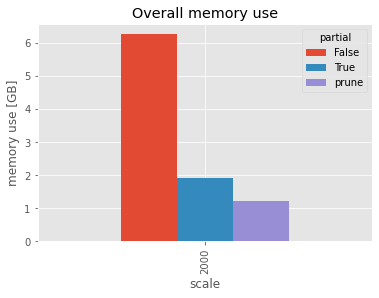

<Figure size 432x288 with 0 Axes>

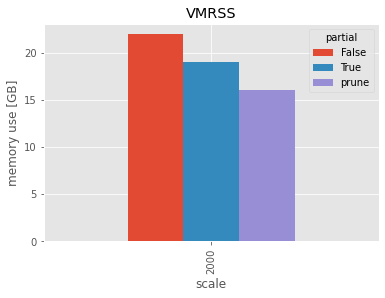

<Figure size 432x288 with 0 Axes>

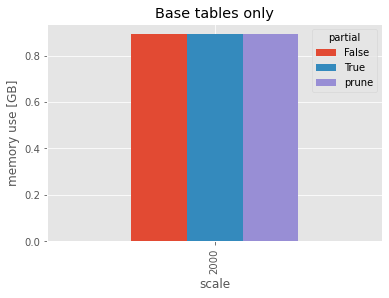

<Figure size 432x288 with 0 Axes>

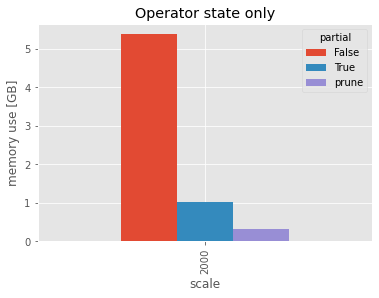

In [223]:
# memory use at various lobsters scales
data = lobsters_experiments
shared_scale = data.reset_index().groupby("partial")["scale"].max().min()
shared_scale = int(shared_scale / 500)
def next_power_of_2(x):  
    return 1 if x == 0 else 2**(x - 1).bit_length()
shared_scale = next_power_of_2(shared_scale) / 2 * 500
print('Showing memory use at %dx scaling factor' % shared_scale)
data = data.query('scale == %d' % (shared_scale)).reset_index()
if shared_scale == limited_lobsters_scale:
    limited = limited_lobsters.copy()
    limited = limited.reset_index()
    limited.partial = "prune"
    data = pd.concat([data.reset_index(), limited])
#data.groupby("partial")["vmrss"].max().unstack("partial").plot.bar(legend=True)
#plt.figure()
data = data.set_index(["scale", "partial"]).unstack("partial")
ax = data["mem"].plot.bar(title="Overall memory use")
ax.set_ylabel("memory use [GB]")
plt.figure()
ax = data["vmrss"].plot.bar(title="VMRSS")
ax.set_ylabel("memory use [GB]")
plt.figure()
ax = data["basemem"].plot.bar(title="Base tables only")
ax.set_ylabel("memory use [GB]")
plt.figure()
ax = data["opmem"].plot.bar(title="Operator state only")
ax.set_ylabel("memory use [GB]")
pass

### Vote memory use: partial vs full, skewed vs uniform

We then go on to demonstrate how this is affected by the size of the working set.
In vote, when the key distribution is uniform, partial does not save much in terms of memory.
But as the working set becomes a smaller fraction of the data size, partial saves memory.

Showing memory use at 800000 ops/s


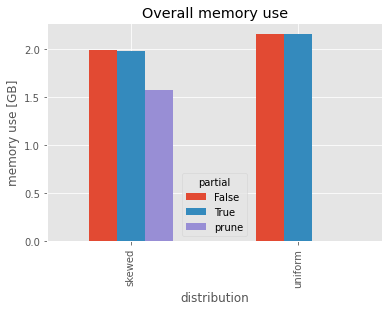

<Figure size 432x288 with 0 Axes>

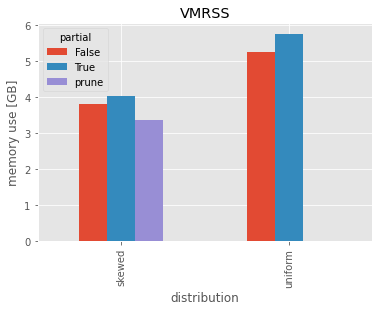

<Figure size 432x288 with 0 Axes>

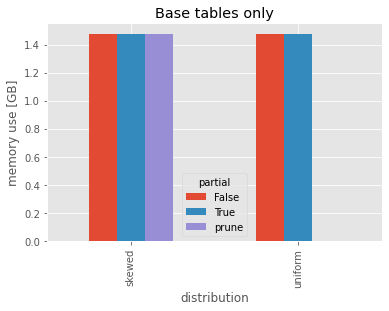

<Figure size 432x288 with 0 Axes>

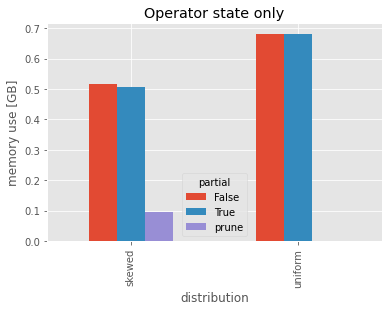

<Figure size 432x288 with 0 Axes>

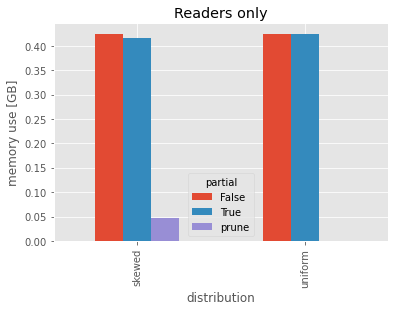

<Figure size 432x288 with 0 Axes>

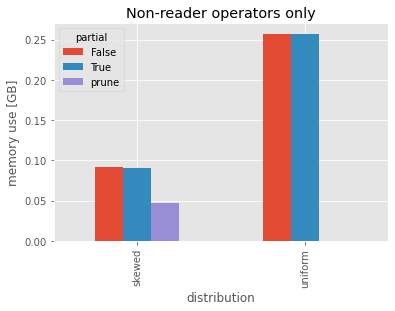

In [224]:
# here, we want to find the largest _target_ that any setup could support
# and then we want to plot the mem size _at that target_ for all setups
data = vote_experiments
shared_target = data.reset_index().groupby(["partial", "distribution"])["target"].max().min()
shared_target = int(shared_target / 100000)
def next_power_of_2(x):  
    return 1 if x == 0 else 2**(x - 1).bit_length()
shared_target = next_power_of_2(shared_target) / 2 * 100000
print('Showing memory use at %d ops/s' % shared_target)
data = data.query('target == %d' % (shared_target)).copy()
if shared_target == limited_vote_target:
    limited = limited_vote.copy()
    limited = limited.reset_index()
    limited.partial = "prune"
    data = pd.concat([data.reset_index(), limited])
#data.groupby(["distribution", "partial"])["vmrss"].max().unstack("partial").plot.bar(legend=True)
#plt.figure()
ax = data.groupby(["distribution", "partial"])["mem"].max().unstack("partial").plot.bar(legend=True, title="Overall memory use")
ax.set_ylabel("memory use [GB]")
plt.figure()
ax = data.groupby(["distribution", "partial"])["vmrss"].max().unstack("partial").plot.bar(legend=True, title="VMRSS")
ax.set_ylabel("memory use [GB]")
plt.figure()
ax = data.groupby(["distribution", "partial"])["basemem"].max().unstack("partial").plot.bar(legend=True, title="Base tables only")
ax.set_ylabel("memory use [GB]")
plt.figure()
ax = data.groupby(["distribution", "partial"])["opmem"].max().unstack("partial").plot.bar(legend=True, title="Operator state only")
ax.set_ylabel("memory use [GB]")
plt.figure()
ax = data.groupby(["distribution", "partial"])["rmem"].max().unstack("partial").plot.bar(legend=True, title="Readers only")
ax.set_ylabel("memory use [GB]")
plt.figure()
ax = data.groupby(["distribution", "partial"])["aggmem"].max().unstack("partial").plot.bar(legend=True, title="Non-reader operators only")
ax.set_ylabel("memory use [GB]")
pass

#### Exploration: memory use as target load increases

This is mostly an internal measurement. As load increases, even with a skewed distribution, we expect that almost all of the tail will be hit. This plots the memory use with increasing load so that we can see that that is indeed the case.

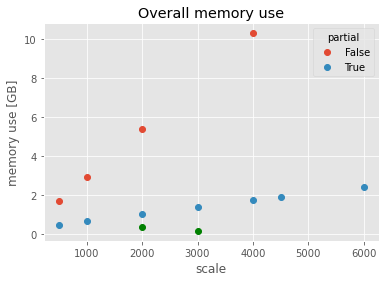

In [225]:
data = lobsters_experiments
d = data.reset_index().set_index(["partial", "scale"])
d = d.sort_index()
bars = lobsters.query("memlimit != 0 & achieved >= 0.99 * requested").reset_index().groupby("scale")["opmem"].min()
#d["vmrss"].unstack(["distribution", "partial"]).interpolate(limit_area='inside').plot(label=True)
#plt.figure()
ax = d["opmem"].unstack("partial").plot(label=True, style="o", title="Overall memory use")
ax.set_xlabel("requested ops/s")
ax.set_ylabel("memory use [GB]")
bars.plot(style='go')
pass

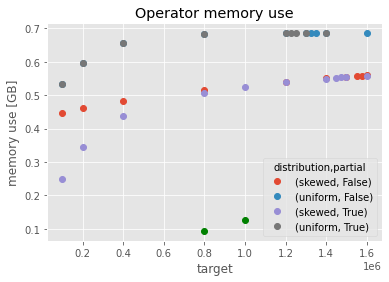

In [226]:
data = vote_experiments
d = data.reset_index().set_index(["partial", "distribution", "target"])
d = d.sort_index()
bars = vote.query("memlimit != 0 & achieved >= 0.99 * target").reset_index().groupby("target")["opmem"].min()
#d["vmrss"].unstack(["distribution", "partial"]).interpolate(limit_area='inside').plot(label=True)
#plt.figure()
ax = d["opmem"].unstack(["distribution", "partial"]).plot(label=True, style="o", title="Operator memory use")
ax.set_xlabel("requested ops/s")
ax.set_ylabel("memory use [GB]")
bars.plot(style='go')
pass

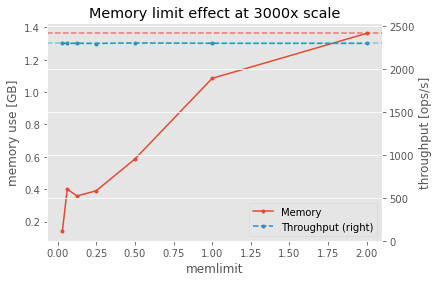

In [227]:
high_limited_scale = 3000
data = lobsters.query('op == "all" & scale == %d & partial == True' % high_limited_scale).groupby('memlimit').tail(1)
d = data.reset_index().set_index("memlimit")
bar = d.query("memlimit == 0")
d = d.query("memlimit != 0")
d = d.sort_index()
#d["vmrss"].unstack(["distribution", "partial"]).interpolate(limit_area='inside').plot(label=True)
#plt.figure()
plt.axhline(y=bar["opmem"].max(), color='r', alpha=0.5, linestyle='--')
ax = d["opmem"].plot(style='.-', legend=True, label="Memory", title="Memory limit effect at %dx scale" % high_limited_scale)
ax.set_xlabel("memory limit [GB]")
ax.set_ylabel("memory use [GB]")
ax = d["achieved"].plot(secondary_y=True, legend=True, style='.--', label="Throughput")
plt.axhline(y=bar["achieved"].max(), color='c', alpha=0.5, linestyle='--')
ax.set_ylabel("throughput [ops/s]")
ax.set_ylim(0, bar["achieved"].max() * 1.1)
plt.show()

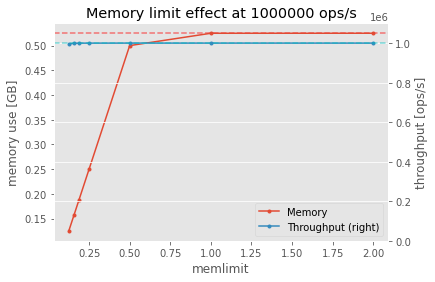

In [228]:
high_limit_target = 1000000
data = vote.query('op == "all" & target == %d & partial == True & distribution == "skewed"' % high_limit_target).groupby('memlimit').tail(1)
d = data.reset_index().set_index("memlimit")
bar = d.query("memlimit == 0")
d = d.query("memlimit != 0")
d = d.sort_index()
#d["vmrss"].unstack(["distribution", "partial"]).interpolate(limit_area='inside').plot(label=True)
#plt.figure()
plt.axhline(y=bar["opmem"].max(), color='r', alpha=0.5, linestyle='--')
ax = d["opmem"].plot(style='.-', legend=True, label="Memory", title="Memory limit effect at %d ops/s" % high_limit_target)
ax.set_xlabel("memory limit [GB]")
ax.set_ylabel("memory use [GB]")
ax = d["achieved"].plot(secondary_y=True, legend=True, style='.-', label="Throughput")
plt.axhline(y=bar["achieved"].max(), color='c', alpha=0.5, linestyle='--')
ax.set_ylabel("throughput [ops/s]")
ax.set_ylim(0, bar["target"].max() * 1.1)
plt.show()

## How does partial materialization affect application performance?

Here, we want to demonstrate that enabling partial does not significantly reduce overall application performance. If it did, developer would be hesitant to use partial in the first place.

### Supported Lobsters load

We start by showing the Lobsters benchmark, and demonstrating that the systems fall over at the same point.

**This benchmark, while showing what we want, is currently a little weird. The full materialization benchmark falls over because the server runs out of memory (128GB), while the partial benchmark falls over due to sojourn latency spiking. I could change to an AWS machine with more memory, but generally that means more cores, which we _don't_ want to increase...**

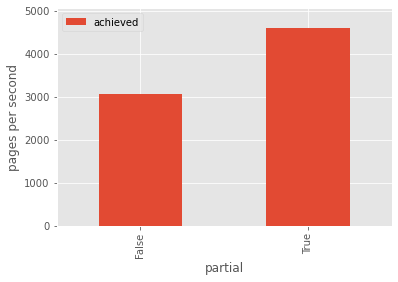

In [229]:
data = lobsters_experiments
data = data.reset_index().set_index(["partial", "scale"])
data = data["achieved"].groupby("partial").max()
ax = data.plot.bar(legend=True)
ax.set_ylabel("pages per second")
ax.set_ylim(0, max_pps)
pass

### Supported vote load

We want to demonstrate that the same holds for vote, and how the size of the working set affects things.

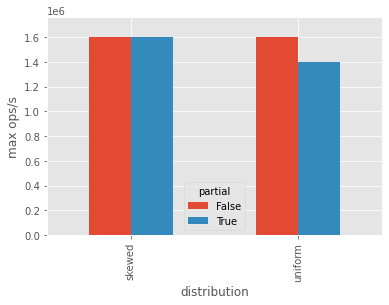

In [230]:
data = vote_experiments
d = data.reset_index().set_index(["partial", "distribution", "target"])
d = d["achieved"].groupby(["partial", "distribution"]).max().unstack("partial")
ax = d.plot.bar(legend=True)
ax.set_ylabel("max ops/s")
ax.set_ylim(0, max_target)
pass

### Latency impact

While throughput is a good high-level measurement, we also know that partial increases the latency of operations that must upquery. To investigate the impact of that, let us look at the 95%-ile latency across all pages in Lobsters.

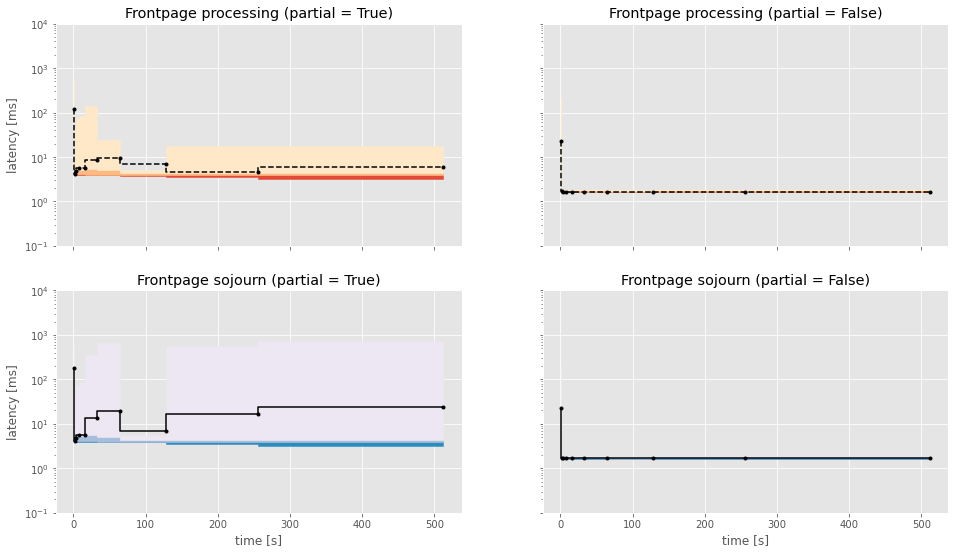

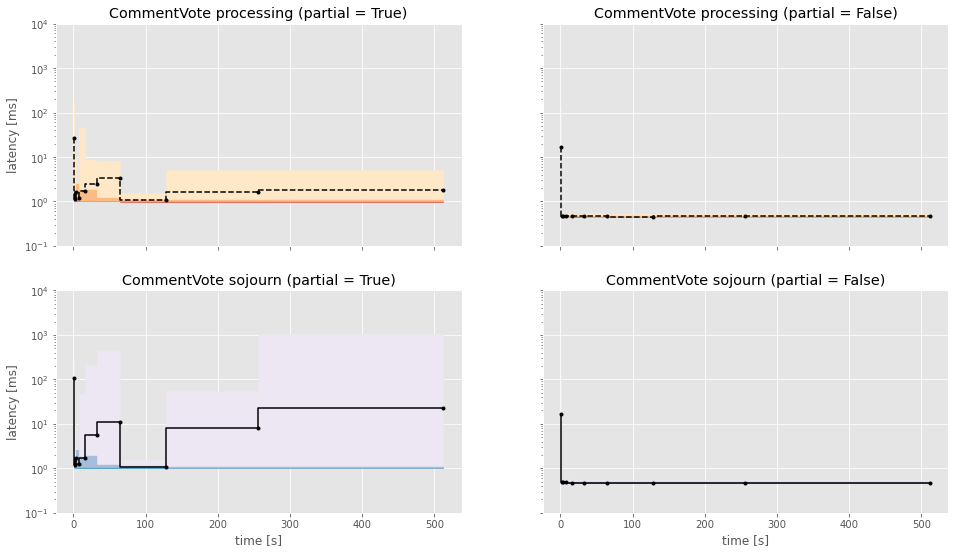

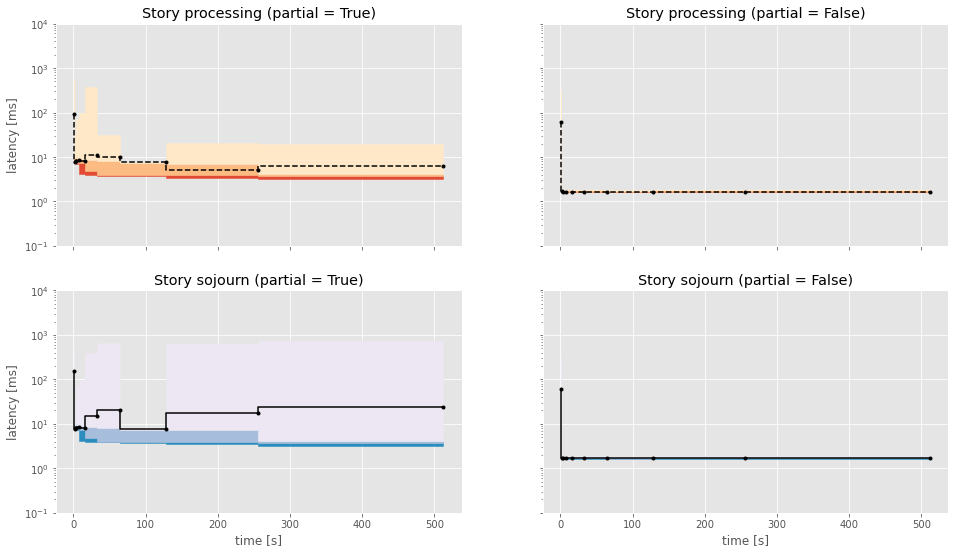

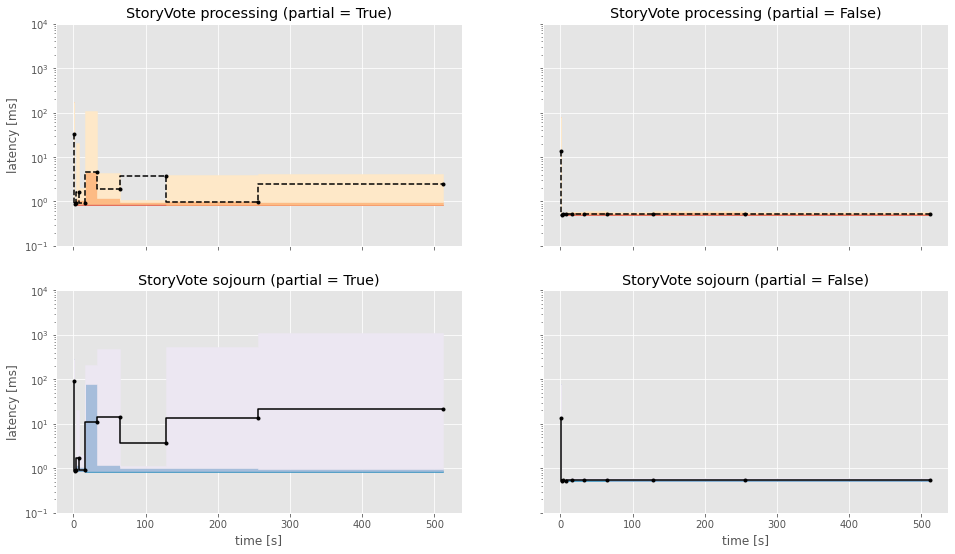

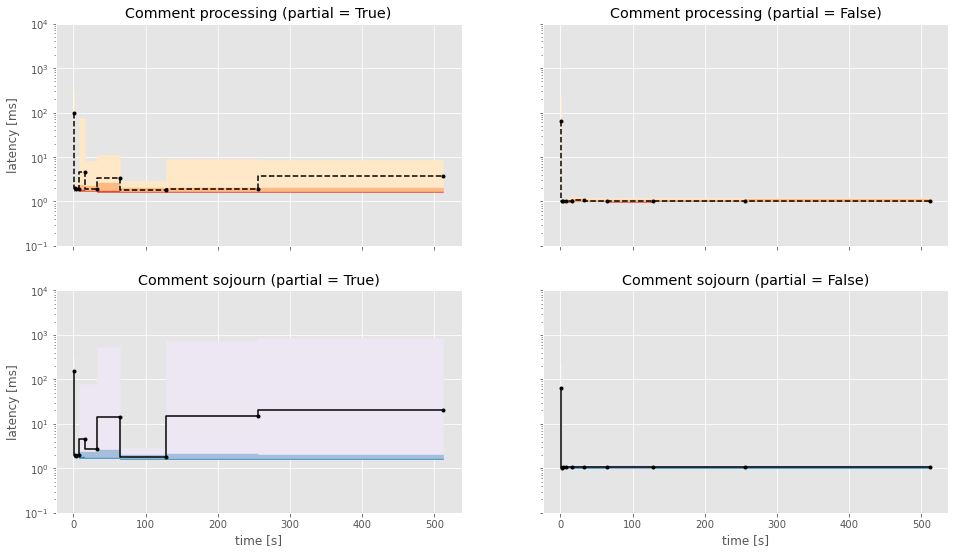

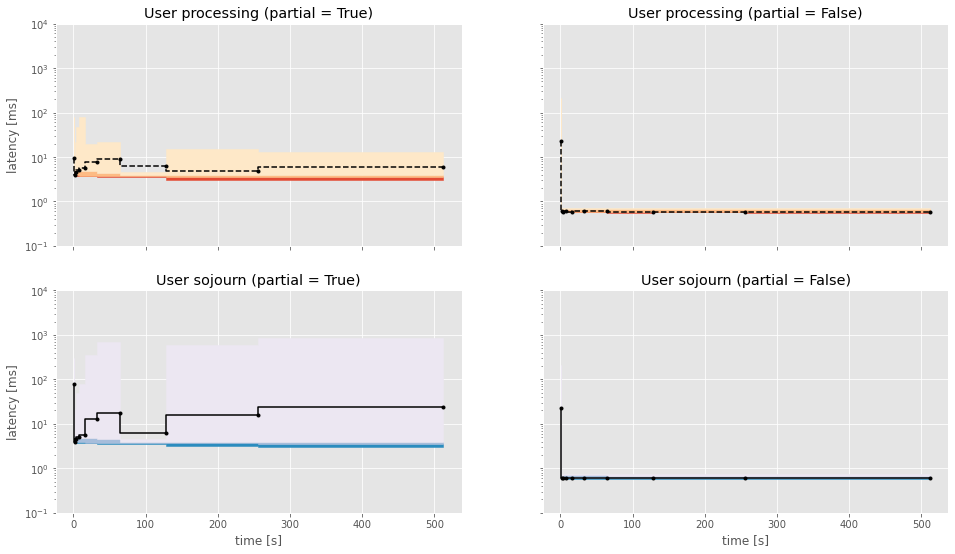

In [231]:
df = lobsters.query('scale == %d & memlimit == 0' % shared_scale).reset_index().set_index(["op", "partial"])
colors = {
    'processing': ['#e34a33', '#fdbb84', '#fee8c8'],
    'sojourn': ['#2b8cbe', '#a6bddb', '#ece7f2']
}
for op in ["Frontpage", "CommentVote", "Story", "StoryVote", "Comment", "User"]:
    fig, (processing, sojourn) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16,9))
    for (metric, ax) in [("processing", processing), ("sojourn", sojourn)]:
        i = 0
        for partial in [True, False]:
            d = df.query("metric == '%s' & partial == %s & op == '%s'" % (metric, partial, op))
            ax[i].step(
                d["until"],
                d["mean"],
                'k.--' if metric == "processing" else "k.-",
                where="pre"
            )
            ax[i].fill_between(d["until"], d["p25"], d["median"], step="pre", color=colors[metric][0])
            ax[i].fill_between(d["until"], d["median"], d["p95"], step="pre", color=colors[metric][1])
            ax[i].fill_between(d["until"], d["p95"], d["p99"], step="pre", color=colors[metric][2])
            if partial:
                ax[i].set_ylabel('latency [ms]')
            if metric == "sojourn":
                ax[i].set_xlabel('time [s]')
            ax[i].set_ylim(0.1, 10000)
            ax[i].set_title("%s %s (partial = %s)" % (op, metric, partial))
            # ax[i].set_aspect('equal')
            ax[i].set_yscale('log')
            i += 1
plt.show()

And the same for vote.

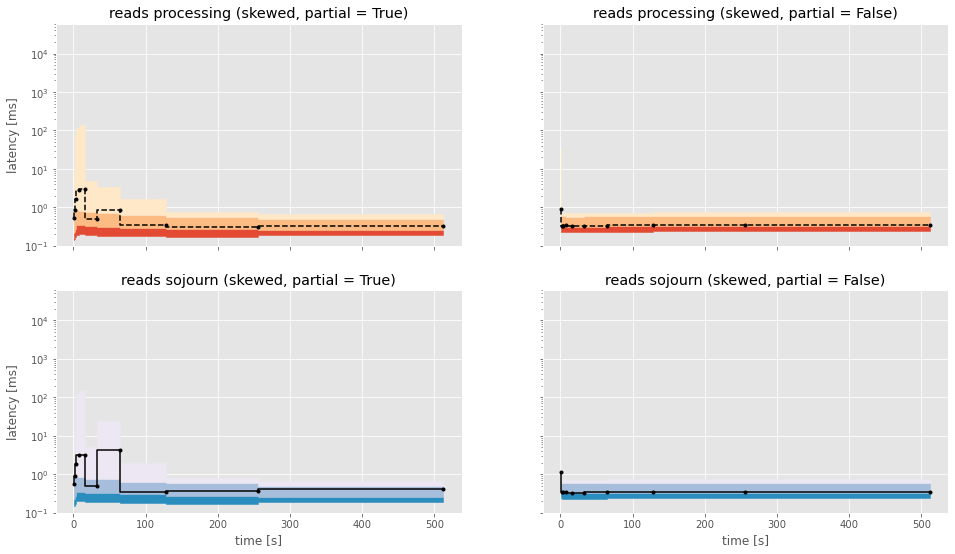

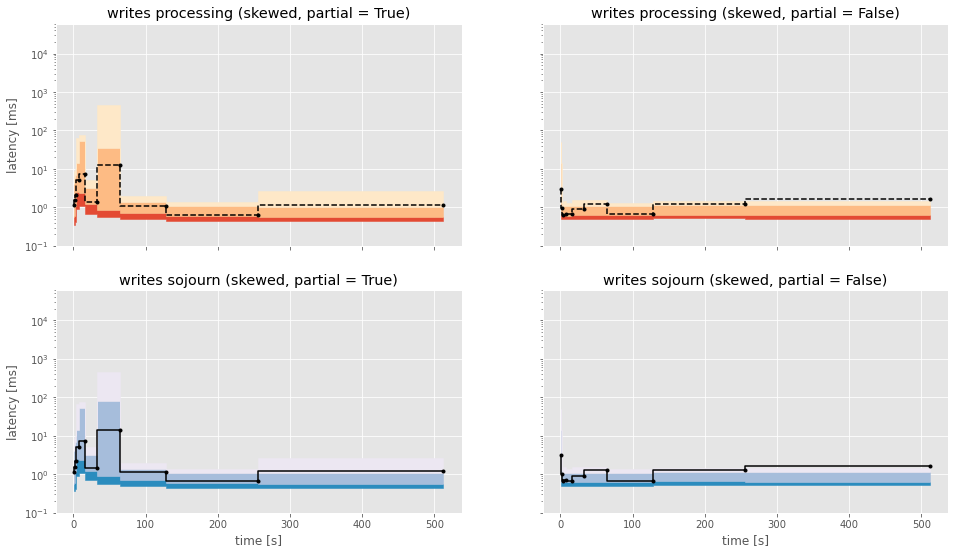

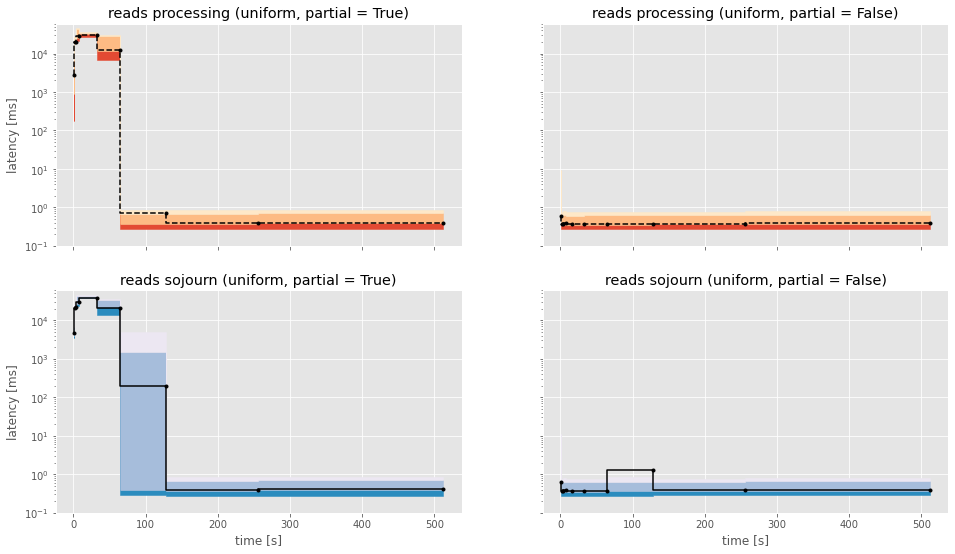

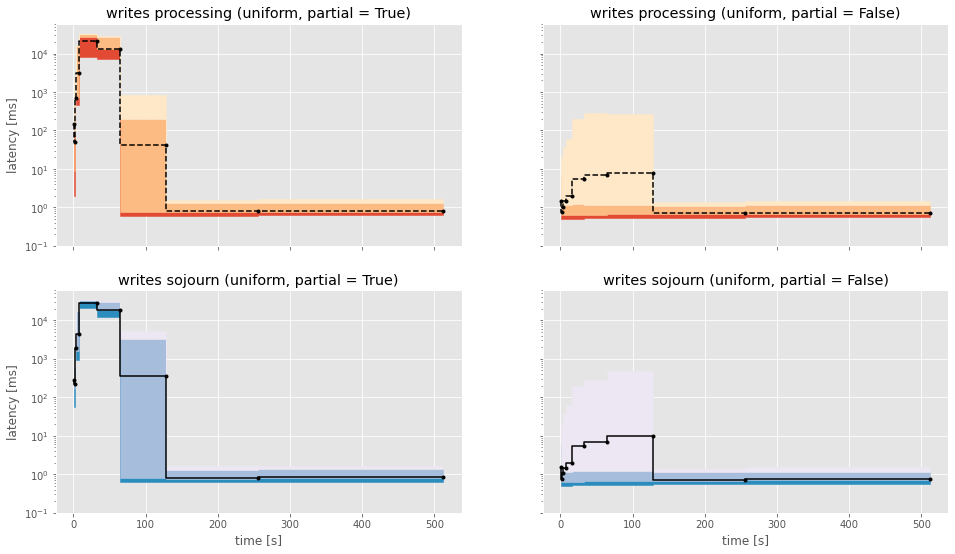

In [232]:
df = vote.query('clients == 6 & write_every == 20 & memlimit == 0 & target == %d' % shared_target).reset_index().set_index(["op", "distribution", "partial"])
colors = {
    'processing': ['#e34a33', '#fdbb84', '#fee8c8'],
    'sojourn': ['#2b8cbe', '#a6bddb', '#ece7f2']
}
for distribution in ["skewed", "uniform"]:
    for op in ["reads", "writes"]:
        fig, (processing, sojourn) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16,9))
        for (metric, ax) in [("processing", processing), ("sojourn", sojourn)]:
            i = 0
            for partial in [True, False]:
                d = df.query("metric == '%s' & partial == %s & distribution == '%s' & op == '%s'" % (metric, partial, distribution, op))
                ax[i].step(
                    d["until"],
                    d["mean"],
                    'k.--' if metric == "processing" else "k.-",
                    where="pre"
                )
                ax[i].fill_between(d["until"], d["p25"], d["median"], step="pre", color=colors[metric][0])
                ax[i].fill_between(d["until"], d["median"], d["p95"], step="pre", color=colors[metric][1])
                ax[i].fill_between(d["until"], d["p95"], d["p99"], step="pre", color=colors[metric][2])
                if partial:
                    ax[i].set_ylabel('latency [ms]')
                if metric == "sojourn":
                    ax[i].set_xlabel('time [s]')
                ax[i].set_title("%s %s (%s, partial = %s)" % (op, metric, distribution, partial))
                ax[i].set_ylim(0.1, 60000)
                # ax[i].set_aspect('equal')
                ax[i].set_yscale('log')
                i += 1
plt.show()

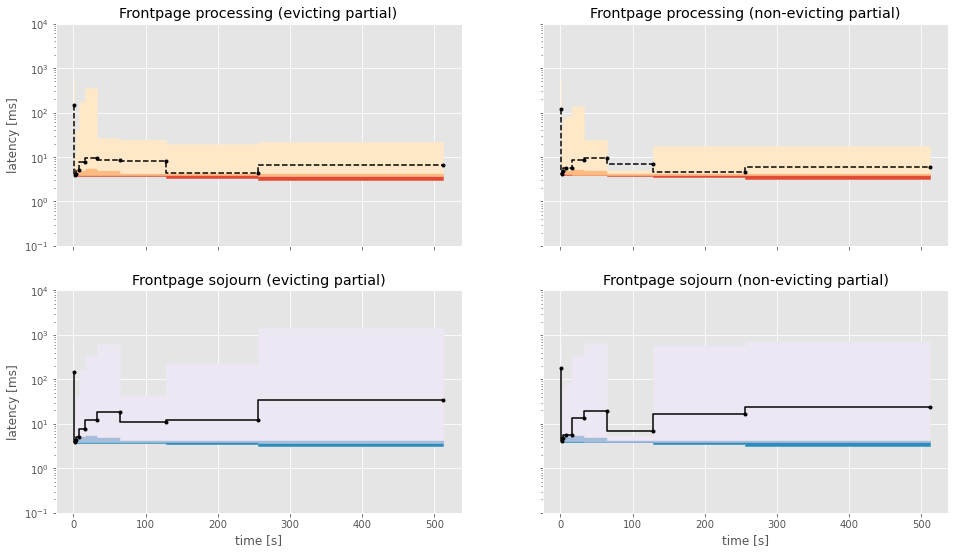

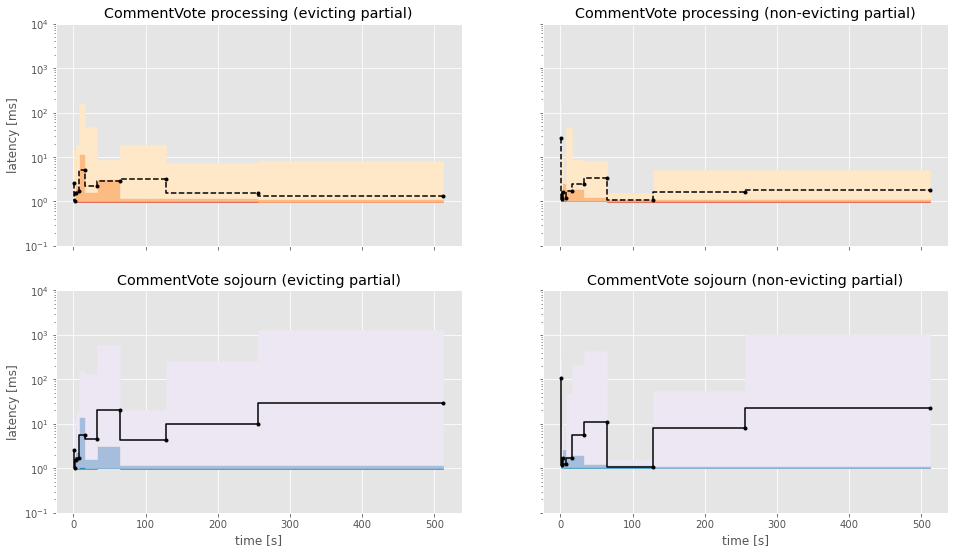

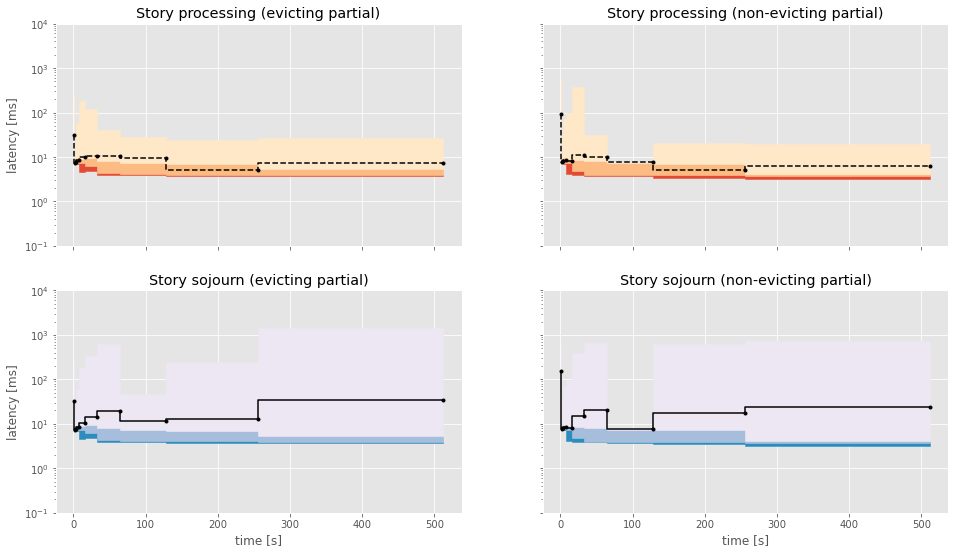

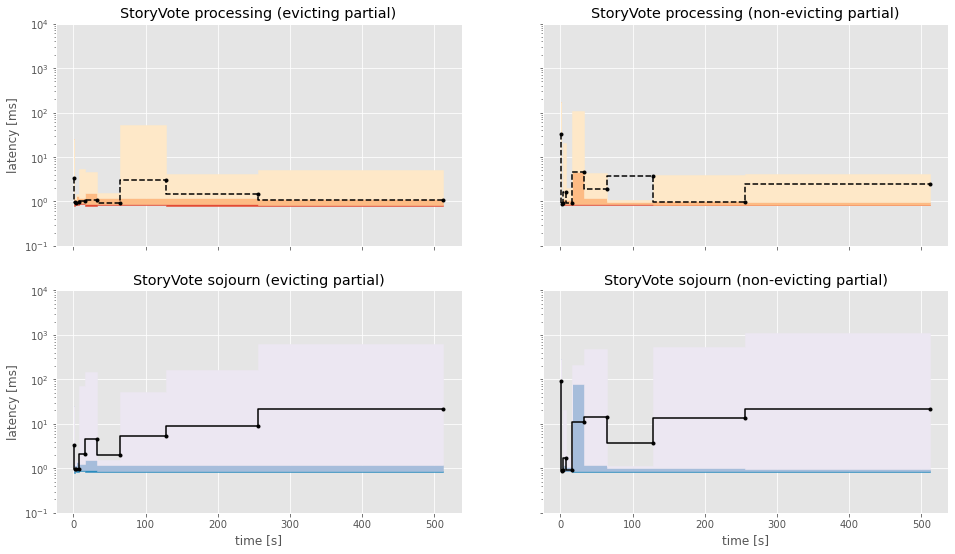

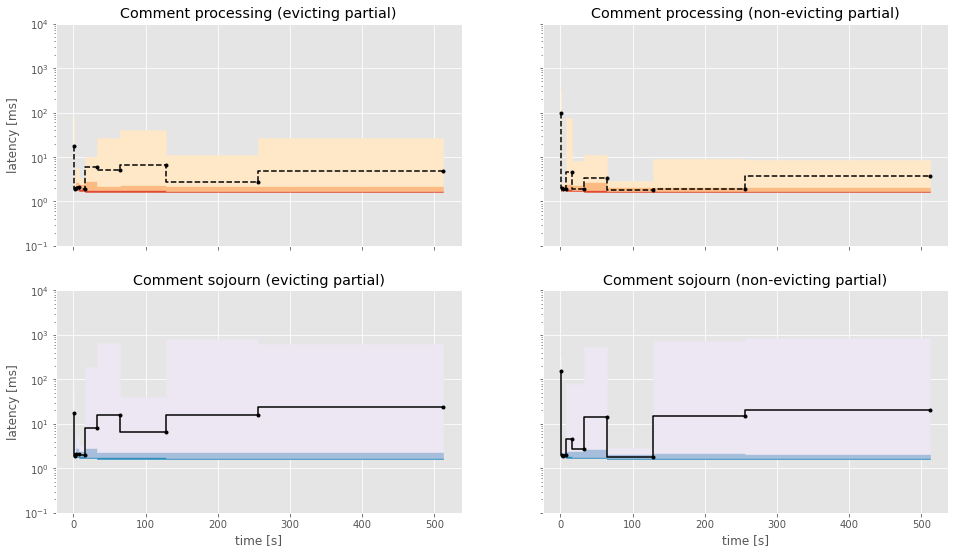

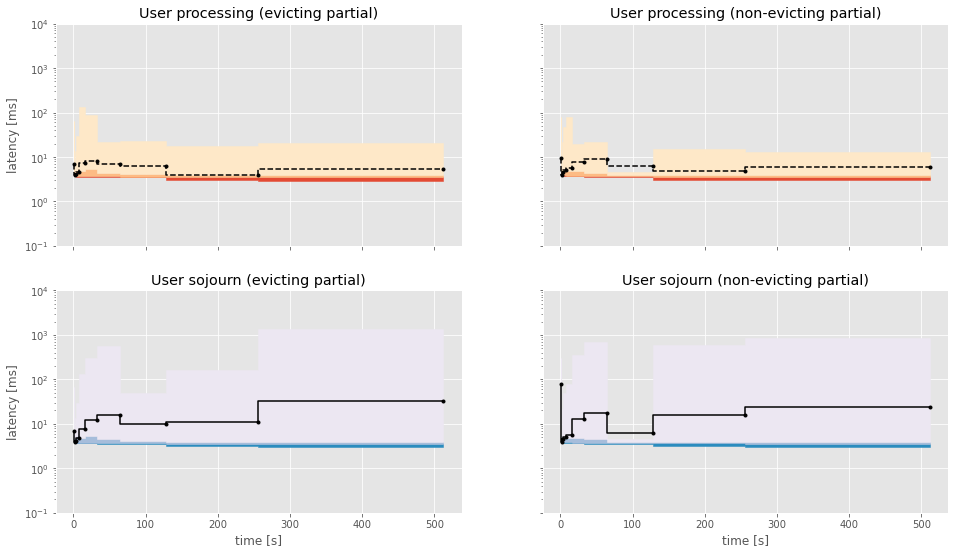

In [233]:
df = [
    lobsters.query('op != "all" & memlimit == %f & scale == %d' % (limited_lobsters_still_ok, limited_lobsters_scale)).reset_index().set_index("op"),
    lobsters.query('partial == True & memlimit == 0 & scale == %d' % limited_lobsters_scale).reset_index().set_index("op")
]
for op in ["Frontpage", "CommentVote", "Story", "StoryVote", "Comment", "User"]:
    fig, (processing, sojourn) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16,9))
    for (metric, ax) in [("processing", processing), ("sojourn", sojourn)]:
        for i in [0, 1]:
            d = df[i].query("metric == '%s' & op == '%s'" % (metric, op))
            ax[i].step(
                d["until"],
                d["mean"],
                'k.--' if metric == "processing" else "k.-",
                where="pre"
            )
            ax[i].fill_between(d["until"], d["p25"], d["median"], step="pre", color=colors[metric][0])
            ax[i].fill_between(d["until"], d["median"], d["p95"], step="pre", color=colors[metric][1])
            ax[i].fill_between(d["until"], d["p95"], d["p99"], step="pre", color=colors[metric][2])
            if metric == "sojourn":
                ax[i].set_xlabel('time [s]')
            if i == 0:
                ax[i].set_ylabel('latency [ms]')
            ax[i].set_title("%s %s (%s partial)" % (op, metric, "evicting" if i == 0 else "non-evicting"))
            ax[i].set_ylim(0.1, 10000)
            # ax.set_aspect('equal')
            ax[i].set_yscale('log')
plt.show()

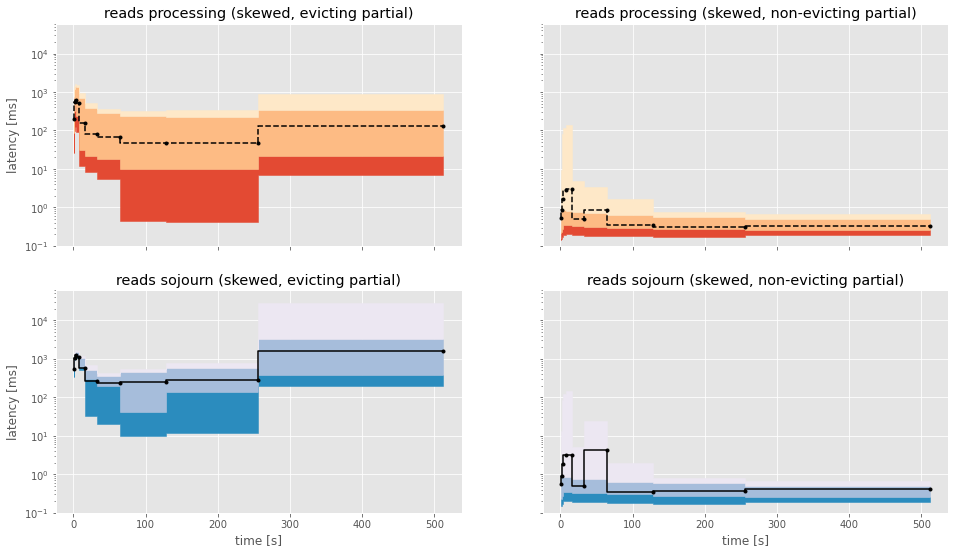

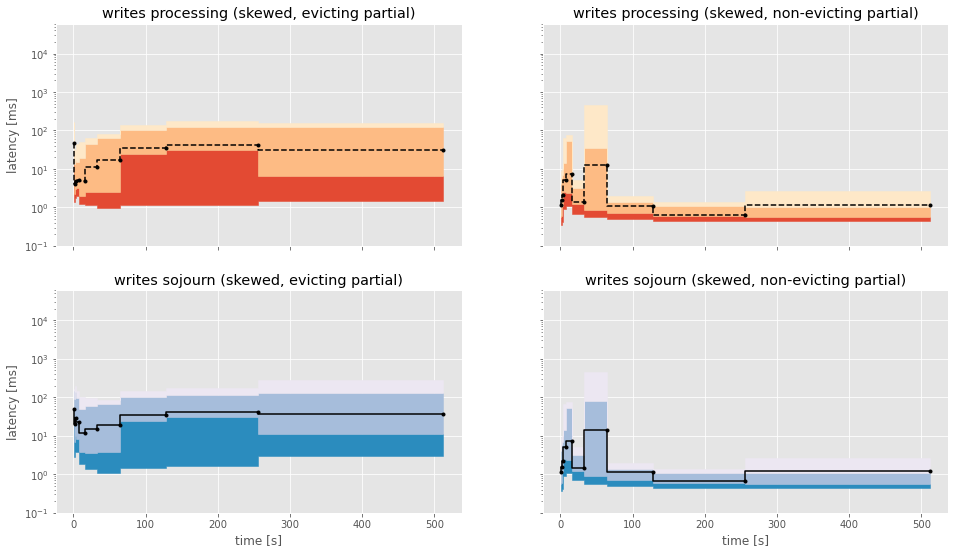

In [234]:
df = [
    vote.query('op != "all" & memlimit == %f & target == %d' % (limited_vote_still_ok, limited_vote_target)).reset_index().set_index("op"),
    vote.query('distribution == "skewed" & partial == True & clients == 6 & write_every == 20 & memlimit == 0 & target == %d' % limited_vote_target).reset_index().set_index("op")
]
for op in ["reads", "writes"]:
    fig, (processing, sojourn) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16,9))
    for (metric, ax) in [("processing", processing), ("sojourn", sojourn)]:
        for i in [0, 1]:
            d = df[i].query("metric == '%s' & op == '%s'" % (metric, op))
            ax[i].step(
                d["until"],
                d["mean"],
                'k.--' if metric == "processing" else "k.-",
                where="pre"
            )
            ax[i].fill_between(d["until"], d["p25"], d["median"], step="pre", color=colors[metric][0])
            ax[i].fill_between(d["until"], d["median"], d["p95"], step="pre", color=colors[metric][1])
            ax[i].fill_between(d["until"], d["p95"], d["p99"], step="pre", color=colors[metric][2])
            if metric == "sojourn":
                ax[i].set_xlabel('time [s]')
            if i == 0:
                ax[i].set_ylabel('latency [ms]')
            ax[i].set_title("%s %s (skewed, %s partial)" % (op, metric, "evicting" if i == 0 else "non-evicting"))
            ax[i].set_ylim(0.1, 60000)
            # ax.set_aspect('equal')
            ax[i].set_yscale('log')
plt.show()

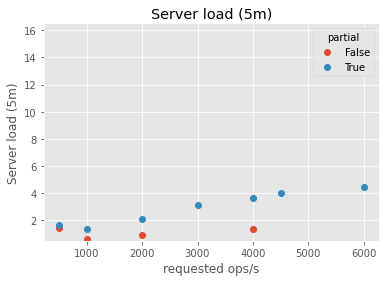

In [235]:
data = lobsters_experiments
d = data.reset_index().set_index(["partial", "scale"])
d = d.sort_index()
ax = d["sload5"].unstack(["partial"]).plot(label=True, style='o', title="Server load (5m)")
ax.set_xlabel("requested ops/s")
ax.set_ylabel("Server load (5m)")
ax.set_ylim(0.5, 16.5)
pass

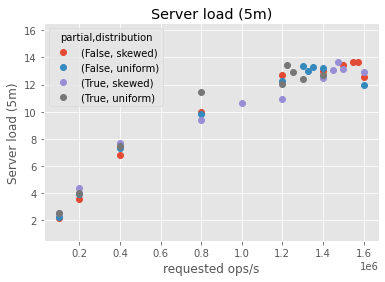

In [236]:
data = vote_experiments
d = data.reset_index().set_index(["partial", "distribution", "target"])
d = d.sort_index()
ax = d["sload5"].unstack(["partial", "distribution"]).plot(label=True, style='o', title="Server load (5m)")
ax.set_xlabel("requested ops/s")
ax.set_ylabel("Server load (5m)")
ax.set_ylim(0.5, 16.5)
pass